API URLs 

shootings - https://services1.arcgis.com/79kfd2K6fskCAkyg/arcgis/rest/services/Gun_Violence_Data/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson



In [532]:
import pandas as pd
import sqlite3
import os
import requests
import json

# Imports

In [533]:
# import pandas as pd
# import os
# import requests


# def fetch_gun_violence_data(output_dir='../../data',
#                             output_file='shootings.csv', batch_size=1000):
#     """
#     Fetches gun violence data from the Louisville ArcGIS FeatureServer
#     and saves it as a CSV.

#     Parameters:
#     -----------
#     output_dir : str
#         Directory where the CSV will be saved.
#     output_file : str
#         CSV filename.
#     batch_size : int
#         Number of records to fetch per request (pagination).

#     Returns:
#     --------
#     pd.DataFrame
#         The full dataset as a DataFrame.
#     """
#     url = 'https://services1.arcgis.com/79kfd2K6fskCAkyg/arcgis/rest/services/Gun_Violence_Data/FeatureServer/0/query'

#     offset = 0
#     data_list = []

#     params = {
#         'where': '1=1',
#         'outFields': '*',
#         'returnGeometry': 'false',
#         'f': 'json',
#         'resultOffset': offset,
#         'resultRecordCount': batch_size
#     }

#     while True:
#         params['resultOffset'] = offset
#         response = requests.get(url, params=params)
#         print(f"Requesting URL: {response.url}")

#         if response.status_code != 200:
#             print(f"Error {response.status_code}: {response.text}")
#             break

#         try:
#             query_result = response.json()
#         except ValueError:
#             print(f"Failed to parse JSON response: {response.text}")
#             break

#         features = query_result.get('features', [])
#         if not features:
#             break

#         for feature in features:
#             data_list.append(feature['attributes'])

#         if len(features) < batch_size:
#             break

#         offset += batch_size

#     if data_list:
#         df = pd.DataFrame(data_list)
#         os.makedirs(output_dir, exist_ok=True)
#         output_path = os.path.join(output_dir, output_file)
#         df.to_csv(output_path, index=False)
#         print(f"Data saved to {output_path}")
#         return df
#     else:
#         print("No data retrieved.")
#         return pd.DataFrame()

# Read in data 

In [534]:
data = pd.read_csv('../../data/shootings.csv')
data.head()

,Case_Number,DateTime,Address,Neighborhood,Council_District,Latitude,Longitude,ZIP_Code,Crime_Type,Cause,Sex,Race,Age_Group,Division_Name,ObjectId
0,8010097010,1291773600000,"N 33rd St @ Bank St, Louisville, Ky",Portland,5.0,38.272650,-85.800687,40212,Non-Fatal Shooting,Gun Shot Wound,MALE,WHITE,25-34,First,1
1,8010097306,1291867200000,"Dixie Hwy @ W Gaulbert Ave, Louisville, Ky",Algonquin,6.0,38.227553,-85.790800,40210,Homicide,Gun Shot Wound,MALE,BLACK,18-24,Second,2
2,8010097982,1292104800000,"1700 Block Of Patton Ct, Louisville, Ky",Algonquin,6.0,38.224834,-85.778739,40210,Non-Fatal Shooting,Gun Shot Wound,MALE,BLACK,18-24,Second,3
3,8010098167,1292155200000,"S 30th St @ W Muhammad Ali Blvd, Louisville, Ky",Russell,5.0,38.255901,-85.800531,40212,Homicide,Gun Shot Wound,MALE,BLACK,25-34,First,4
4,8010099052,1292443200000,"3600 Block Of Manslick Rd, Louisville, Ky",Jacobs,3.0,38.195354,-85.799650,40215,Homicide,Blunt force Trauma,MALE,WHITE,1-10,Fourth,5


In [535]:
def prepare_crime_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    Prepares and cleans the crime dataset for analysis or database insertion.

    Parameters:
    -----------
    data : pd.DataFrame
        Raw crime data with columns like 'DateTime', 'ZIP_Code', 'Council_District', etc.

    Returns:
    --------
    pd.DataFrame
        Cleaned and prepared DataFrame with:
        - 'DateTime' normalized and formatted
        - 'Date' column extracted
        - Numeric columns cast correctly
        - Text columns stripped, title-cased, and missing values filled
    """
    
    # Convert DateTime from milliseconds, normalize and format
    data['DateTime'] = pd.to_datetime(data['DateTime'], unit='ms').dt.normalize()
    data['DateTime'] = data['DateTime'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    # Extract just the date
    data['Date'] = data['DateTime'].str[:10]
    
    # Convert Council_District to nullable integer
    data['Council_District'] = data['Council_District'].astype('Int64')
    
    # Ensure ZIP_Code is string
    data['ZIP_Code'] = data['ZIP_Code'].astype(str)
    
    # Columns to clean text
    text_cols = ['Neighborhood', 'Crime_Type', 'Cause', 'Sex', 'Race', 'Age_Group', 'Division_Name']
    for col in text_cols:
        data[col] = data[col].astype(str).str.strip().str.title()
    
    # Fill missing demographic data
    demo_cols = ['Cause', 'Sex', 'Race', 'Age_Group']
    data[demo_cols] = data[demo_cols].fillna('Unknown')
    
    return data


In [536]:
data = prepare_crime_data(data)
data.head()

,Case_Number,DateTime,Address,Neighborhood,Council_District,Latitude,Longitude,ZIP_Code,Crime_Type,Cause,Sex,Race,Age_Group,Division_Name,ObjectId,Date
0,8010097010,2010-12-08 00:00:00,"N 33rd St @ Bank St, Louisville, Ky",Portland,5,38.272650,-85.800687,40212,Non-Fatal Shooting,Gun Shot Wound,Male,White,25-34,First,1,2010-12-08
1,8010097306,2010-12-09 00:00:00,"Dixie Hwy @ W Gaulbert Ave, Louisville, Ky",Algonquin,6,38.227553,-85.790800,40210,Homicide,Gun Shot Wound,Male,Black,18-24,Second,2,2010-12-09
2,8010097982,2010-12-11 00:00:00,"1700 Block Of Patton Ct, Louisville, Ky",Algonquin,6,38.224834,-85.778739,40210,Non-Fatal Shooting,Gun Shot Wound,Male,Black,18-24,Second,3,2010-12-11
3,8010098167,2010-12-12 00:00:00,"S 30th St @ W Muhammad Ali Blvd, Louisville, Ky",Russell,5,38.255901,-85.800531,40212,Homicide,Gun Shot Wound,Male,Black,25-34,First,4,2010-12-12
4,8010099052,2010-12-15 00:00:00,"3600 Block Of Manslick Rd, Louisville, Ky",Jacobs,3,38.195354,-85.799650,40215,Homicide,Blunt Force Trauma,Male,White,1-10,Fourth,5,2010-12-15


# Generate Database

```sql
-- Table 1: Address
CREATE TABLE IF NOT EXISTS Address (
    ObjectId INTEGER PRIMARY KEY,
    Address TEXT,
    Neighborhood TEXT,
    ZIP_Code TEXT
);

-- Table 2: CaseInfo
CREATE TABLE IF NOT EXISTS CaseInfo (
    ObjectId INTEGER PRIMARY KEY,
    Date TEXT,
    Case_Number TEXT,
    Division_Name TEXT,
    Council_District INTEGER,
    Crime_Type TEXT,
    Cause TEXT
);

-- Table 3: Demographics
CREATE TABLE IF NOT EXISTS Demographics (
    ObjectId INTEGER PRIMARY KEY,
    Age_Group TEXT,
    Sex TEXT,
    Race TEXT
);

-- Table 4: Geo
CREATE TABLE IF NOT EXISTS Geo (
    ObjectId INTEGER PRIMARY KEY,
    Latitude REAL,
    Longitude REAL
);
```

In [537]:
def insert_crime_data_to_sqlite(data: pd.DataFrame, db_path: str):
    """
    Inserts a cleaned crime DataFrame into a SQLite database, splitting it into 4 tables:
    Address, CaseInfo, Demographics, and Geo.

    Parameters:
    -----------
    data : pd.DataFrame
        Cleaned DataFrame with all necessary columns.
        Must include 'ObjectId'.
    db_path : str
        Path to SQLite database file.
    """
    # Connect to SQLite
    conn = sqlite3.connect(db_path)

    try:
        # Insert Address table
        address_cols = ['Address', 'Neighborhood', 'ZIP_Code']
        data[['ObjectId'] + address_cols].to_sql(
            'Address',
            conn,
            if_exists='replace',
            index=False
        )

        # Insert CaseInfo table
        caseinfo_cols = ['Date', 'Case_Number', 'Division_Name', 'Council_District', 'Crime_Type', 'Cause']
        data[['ObjectId'] + caseinfo_cols].to_sql(
            'CaseInfo',
            conn,
            if_exists='replace',
            index=False
        )

        # Insert Demographics table
        demo_cols = ['Age_Group', 'Sex', 'Race']
        data[['ObjectId'] + demo_cols].to_sql(
            'Demographics',
            conn,
            if_exists='replace',
            index=False
        )

        # Insert Geo table
        geo_cols = ['Latitude', 'Longitude']
        data[['ObjectId'] + geo_cols].to_sql(
            'Geo',
            conn,
            if_exists='replace',
            index=False
        )

        print(f"Data successfully inserted into SQLite database at: {db_path}")

    finally:
        # Close connection
        conn.close()


In [538]:
db_path = '../../database/crime_data.db'
insert_crime_data_to_sqlite(data, db_path)

Data successfully inserted into SQLite database at: ../../database/crime_data.db


In [539]:
def query(sql_query:str) -> pd.DataFrame:
    conn = sqlite3.connect('../../database/crime_data.db')
    df = pd.read_sql_query(sql_query, conn)
    conn.close()
    return df

```markdown
+----------------+          +----------------+          +----------------+
|    Address     |          |    CaseInfo    |          |  Demographics  |
|----------------|          |----------------|          |----------------|
| ObjectId (PK)  | <--+---> | ObjectId (PK)  | <---+--> | ObjectId (PK)  |
| Address        |    |     | Date           |     |    | Age_Group      |
| Neighborhood   |    |     | Case_Number    |     |    | Sex            |
| ZIP_Code       |    |     | Division_Name  |     |    | Race           |
+----------------+    |     | Council_District|    |    +----------------+
                      |     | Crime_Type     |     |
                      |     | Cause          |     |
                      |     +----------------+     |
                      |                            |
                      |                            |
                      |                            |
                      |     +----------------+     |
                      |     |      Geo       |     |
                      |     |----------------|     |
                      +-----| ObjectId (PK)  |-----+
                            | Latitude       |
                            | Longitude      |
                            +----------------+
```

In [540]:
test = query("SELECT * FROM Demographics LIMIT 5;")
test

,ObjectId,Age_Group,Sex,Race
0,1,25-34,Male,White
1,2,18-24,Male,Black
2,3,18-24,Male,Black
3,4,25-34,Male,Black
4,5,1-10,Male,White


2010-2025

In [541]:
data

,Case_Number,DateTime,Address,Neighborhood,Council_District,Latitude,Longitude,ZIP_Code,Crime_Type,Cause,Sex,Race,Age_Group,Division_Name,ObjectId,Date
0,8010097010,2010-12-08 00:00:00,"N 33rd St @ Bank St, Louisville, Ky",Portland,5,38.272650,-85.800687,40212,Non-Fatal Shooting,Gun Shot Wound,Male,White,25-34,First,1,2010-12-08
1,8010097306,2010-12-09 00:00:00,"Dixie Hwy @ W Gaulbert Ave, Louisville, Ky",Algonquin,6,38.227553,-85.790800,40210,Homicide,Gun Shot Wound,Male,Black,18-24,Second,2,2010-12-09
2,8010097982,2010-12-11 00:00:00,"1700 Block Of Patton Ct, Louisville, Ky",Algonquin,6,38.224834,-85.778739,40210,Non-Fatal Shooting,Gun Shot Wound,Male,Black,18-24,Second,3,2010-12-11
3,8010098167,2010-12-12 00:00:00,"S 30th St @ W Muhammad Ali Blvd, Louisville, Ky",Russell,5,38.255901,-85.800531,40212,Homicide,Gun Shot Wound,Male,Black,25-34,First,4,2010-12-12
4,8010099052,2010-12-15 00:00:00,"3600 Block Of Manslick Rd, Louisville, Ky",Jacobs,3,38.195354,-85.799650,40215,Homicide,Blunt Force Trauma,Male,White,1-10,Fourth,5,2010-12-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67059,521-77002,2025-12-11 00:00:00,"2200 Block of W Oak St, Louisville, Ky",California,4,38.237949,-85.792079,40210,Shotspotter Alert,Nan,Nan,Nan,Nan,Second,67060,2025-12-11
67060,521-77003,2025-12-11 00:00:00,"2200 Block of Rowan St, Louisville, Ky",Portland,5,38.261654,-85.786624,40212,Shotspotter Alert,Nan,Nan,Nan,Nan,First,67061,2025-12-11
67061,LMPD25147790,2025-12-12 00:00:00,"1300 Block of S 28th St, Louisville, Ky",Parkland,1,38.236751,-85.800337,40211,Non-Fatal Shooting,Gun Shot Wound,Male,Black,11-17,Second,67062,2025-12-12
67062,521-77069,2025-12-12 00:00:00,"1300 Block of S 28th St, Louisville, Ky",Parkland,1,38.234812,-85.800796,40211,Shotspotter Alert,Nan,Nan,Nan,Nan,Second,67063,2025-12-12


In [542]:
df_2010 = query("SELECT * FROM CaseInfo WHERE Date LIKE '2010-%';")
df_2010

,ObjectId,Date,Case_Number,Division_Name,Council_District,Crime_Type,Cause
0,1,2010-12-08,8010097010,First,5,Non-Fatal Shooting,Gun Shot Wound
1,2,2010-12-09,8010097306,Second,6,Homicide,Gun Shot Wound
2,3,2010-12-11,8010097982,Second,6,Non-Fatal Shooting,Gun Shot Wound
3,4,2010-12-12,8010098167,First,5,Homicide,Gun Shot Wound
4,5,2010-12-15,8010099052,Fourth,3,Homicide,Blunt Force Trauma
...,...,...,...,...,...,...,...
212,896,2010-06-08,8010042816,Second,1,Non-Fatal Shooting,Gun Shot Wound
213,897,2010-06-12,8010044200,Second,1,Non-Fatal Shooting,Gun Shot Wound
214,898,2010-06-13,8010044338,Second,6,Non-Fatal Shooting,Gun Shot Wound
215,899,2010-06-16,8010045139,Fourth,3,Non-Fatal Shooting,Gun Shot Wound


In [543]:
data['Date'] = pd.to_datetime(data['Date'])

numberOfShooting = (
    data
    .groupby(data['Date'].dt.to_period('M'))
    .size()
    .reset_index(name='num_shootings')
)

numberOfShooting['Date'] = numberOfShooting['Date'].astype(str)


<Axes: title={'center': 'Number of Shootings Over Time'}, xlabel='Date'>

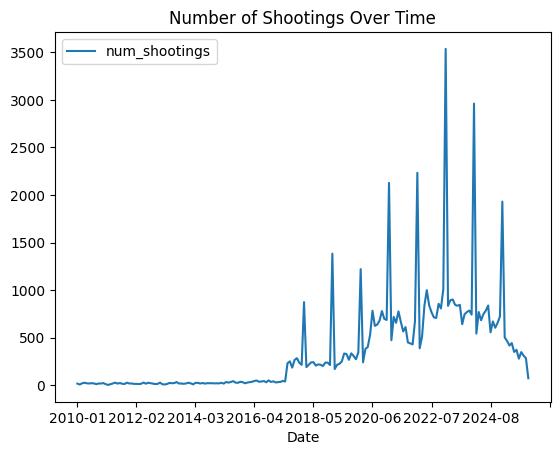

In [544]:
numberOfShooting.plot(x='Date', y='num_shootings', kind='line', title='Number of Shootings Over Time')

In [545]:
data['Date'] = pd.to_datetime(data['Date'])

shootings_by_year = (
    data
    .groupby(data['Date'].dt.to_period('Y'))
    .size()
    .rename('num_shootings')
    .to_frame()
)
shootings_by_year

,num_shootings
Date,
2010,217
2011,200
2012,216
2013,226
2014,238
2015,339
2016,466
2017,1847
2018,3289


<Axes: title={'center': 'Number of Shootings by Year'}, xlabel='Date'>

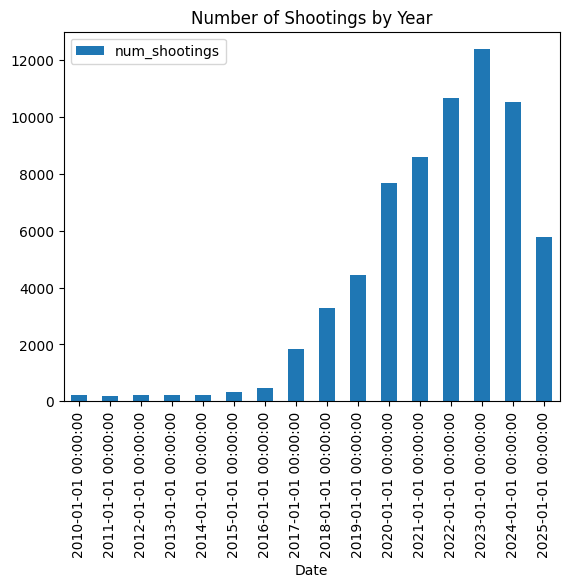

In [546]:
shootings_by_year = shootings_by_year.reset_index()
shootings_by_year['Date'] = shootings_by_year['Date'].dt.to_timestamp()

shootings_by_year.plot(
    x='Date',
    y='num_shootings',
    kind='bar',
    title='Number of Shootings by Year'
)


# exp

In [547]:
# import cartopy.crs as ccrs
# import geopandas as gpd
# import matplotlib.pyplot as plt
# from matplotlib.colors import LinearSegmentedColormap
# import unicodedata

# # --- Fonts ---
# # Fallback to system fonts if you don't want pyfonts
# regular_font = "Roboto"
# bold_font = "Roboto"  # weight applied via fontweight

# # --- Custom colormap ---
# colors = [
#     "#5A1A74",
#     "#661d5c",
#     "#86277A",
#     "#9D2D7A",
#     "#C74370",
#     "#FB9A70",
#     "#FDC48C",
#     "#FED69A",
#     "#FCFCBD",
# ][::-1]

# cmap = LinearSegmentedColormap.from_list("Sunset3", colors)

# # --- Figure and axes ---
# projection = ccrs.PlateCarree()  # define your projection
# fig, ax = plt.subplots(subplot_kw={"projection": projection}, dpi=300)
# ax.axis("off")

# # --- Plot GeoDataFrame ---
# df.plot(
#     ax=ax,
#     column="Werkloosheidsgraad",  # replace with your column
#     cmap=cmap,
#     edgecolor="#e6e6e6",
#     linewidth=0.3,
# )

# # --- Colorbar as inset histogram ---
# bar_ax = ax.inset_axes(bounds=[0.05, 0.15, 0.4, 0.3], zorder=-1)
# n, bins, _ = bar_ax.hist(df["Werkloosheidsgraad"], bins=18, alpha=0)
# colors_bar = [cmap((val - min(bins)) / (max(bins) - min(bins))) for val in bins]
# bar_ax.bar(bins[:-1], n, color=colors_bar)
# bar_ax.spines[["top", "left", "right"]].set_visible(False)
# bar_ax.set_yticks([])
# x_ticks = list(range(0, 19, 3))
# bar_ax.set_xticks(x_ticks)
# bar_ax.set_xticklabels(["0", "3", "6", "9", "12", "15", "18%"], fontsize=8)
# bar_ax.tick_params(axis="x", length=2)

# # --- Titles and captions ---
# fig.text(
#     x=0.2,
#     y=0.89,
#     s="Unemployment rate in Belgium",
#     size=12,
#     fontname=bold_font,
#     fontweight="bold",
# )
# fig.text(
#     x=0.2,
#     y=0.86,
#     s="By municipality, in December 2024",
#     size=8,
#     fontname=regular_font,
# )
# fig.text(
#     x=0.2,
#     y=0.13,
#     s="Map: Koen Van den Eeckhout · Source: RVA (Interactive Statistics)",
#     size=6,
#     color="#909090",
#     fontname=regular_font,
# )

# plt.show()


# other

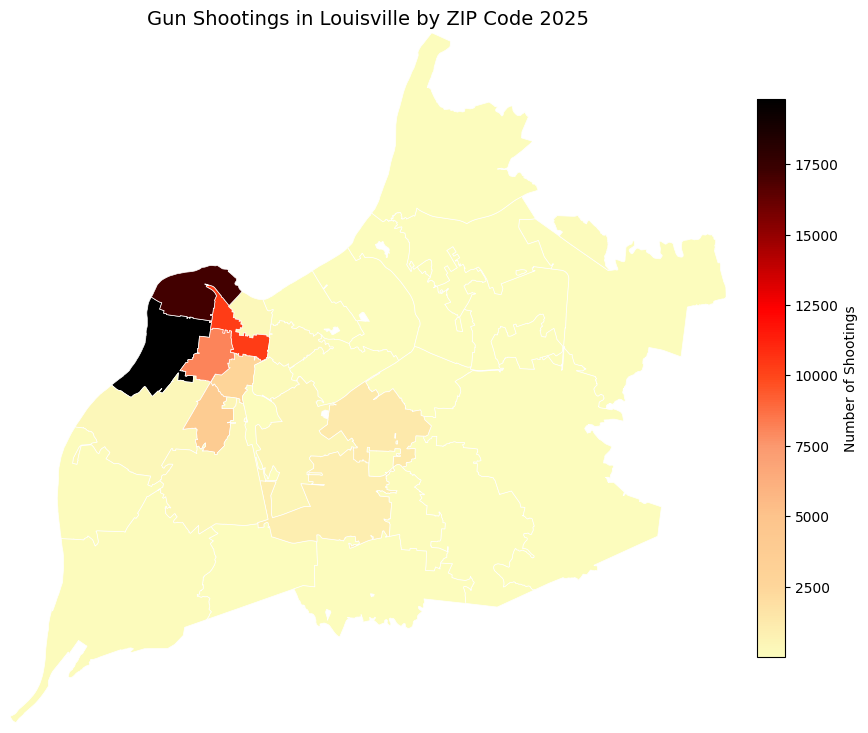

In [548]:
import pandas as pd
import pygris
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

# --- Load cleaned data ---
data['ZIP_Code'] = data['ZIP_Code'].astype(str).str.zfill(5)

# --- Aggregate shootings by ZIP code ---
shootings_by_zip = (
    data.groupby('ZIP_Code')['ObjectId']
    .count()
    .rename('num_shootings')
    .reset_index()
)

# --- Pull KY ZIP code shapefile (2010 ZCTAs) ---
ky_zips = pygris.zctas(state="21", year=2010)
zip_col = [col for col in ky_zips.columns if 'ZCTA' in col][0]

# Merge shooting counts with shapefile
geo_df = ky_zips.merge(shootings_by_zip, left_on=zip_col, right_on='ZIP_Code', how='left')
geo_df['num_shootings'] = geo_df['num_shootings'].fillna(0)

# --- Filter only ZIPs that exist in your data for Louisville ---
geo_df = geo_df[geo_df['ZIP_Code'].isin(data['ZIP_Code'].unique())]

# --- Colormap ---
colors = [
    "#000000", "#3c0000", "#990000", "#FF0000",
    "#FF481B", "#FB9A70", "#FDC48C", "#FED69A", "#FCFCBD"
][::-1]
cmap = LinearSegmentedColormap.from_list("Sunset3", colors)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10,10))
geo_df.plot(
    ax=ax,
    column='num_shootings',
    cmap=cmap,
    edgecolor='white',
    linewidth=0.5,
)

# --- Add legend ---
sm = mpl.cm.ScalarMappable(cmap=cmap, 
                           norm=mpl.colors.Normalize(vmin=geo_df['num_shootings'].min(), 
                                                    vmax=geo_df['num_shootings'].max()))
sm._A = []  # Required for ScalarMappable
cbar = fig.colorbar(sm, ax=ax, fraction=0.036, pad=0.04)
cbar.set_label("Number of Shootings", fontsize=10)

# --- Titles & remove axes ---
ax.set_title("Gun Shootings in Louisville by ZIP Code 2025", fontsize=14)
ax.axis('off')

# --- Zoom into Louisville by bounding box ---
minx, miny, maxx, maxy = geo_df.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.show()


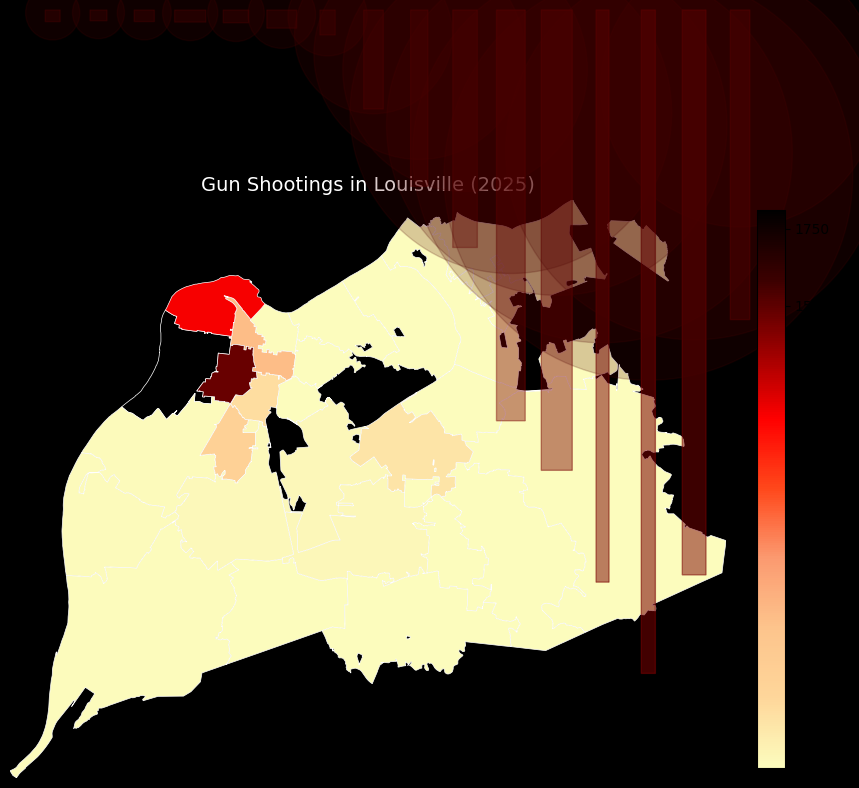

In [549]:
import pandas as pd
import pygris
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import FancyBboxPatch
import matplotlib.dates as mdates
import numpy as np

# --------------------
# PREP DATA
# --------------------
data = data.copy()
data['DateTime'] = pd.to_datetime(data['DateTime'])

# Filter to 2025
data_2025 = data.loc[data['DateTime'].dt.year == 2025].copy()
data_2025['ZIP_Code'] = data_2025['ZIP_Code'].astype(str).str.zfill(5)

# Aggregate shootings by ZIP
shootings_by_zip = (
    data_2025.groupby('ZIP_Code')['ObjectId']
    .count()
    .rename('num_shootings')
    .reset_index()
)

# Aggregate shootings by YEAR (for drips)
shootings_by_year = (
    data.groupby(data['DateTime'].dt.to_period('Y'))
    .size()
    .rename('num_shootings')
    .reset_index()
)
shootings_by_year.columns = ['Date', 'num_shootings']
shootings_by_year['Date'] = shootings_by_year['Date'].dt.to_timestamp()

# --------------------
# LOAD KY ZIP SHAPES
# --------------------
ky_zips = pygris.zctas(state="21", year=2010)
zip_col = [c for c in ky_zips.columns if 'ZCTA' in c][0]

geo_df = ky_zips.merge(
    shootings_by_zip,
    left_on=zip_col,
    right_on='ZIP_Code',
    how='left'
)
geo_df['num_shootings'] = geo_df['num_shootings'].fillna(0)
geo_df = geo_df[geo_df['ZIP_Code'].isin(data_2025['ZIP_Code'].unique())]

# --------------------
# COLOR MAP
# --------------------
colors = [
    "#000000", "#3c0000", "#990000", "#FF0000",
    "#FF481B", "#FB9A70", "#FDC48C", "#FED69A", "#FCFCBD"
][::-1]
cmap = LinearSegmentedColormap.from_list("blood", colors)

# --------------------
# FIGURE LAYOUT
# --------------------
fig = plt.figure(figsize=(10, 14))
gs = fig.add_gridspec(2, 1, height_ratios=[4, 1], hspace=0)
fig.patch.set_facecolor('black')

# --------------------
# MAP (TOP)
# --------------------
ax_map = fig.add_subplot(gs[0])
ax_map.set_facecolor('black')

geo_df.plot(
    ax=ax_map,
    column='num_shootings',
    cmap=cmap,
    edgecolor='white',
    linewidth=0.5
)

ax_map.set_title(
    "Gun Shootings in Louisville (2025)",
    fontsize=14,
    color='white'
)
ax_map.axis('off')

minx, miny, maxx, maxy = geo_df.total_bounds
ax_map.set_xlim(minx, maxx)
ax_map.set_ylim(miny, maxy)

# --------------------
# DRIPS / BARS (BOTTOM)
# --------------------
ax_drip = fig.add_subplot(gs[1])
ax_drip.set_facecolor('black')

max_val = shootings_by_year['num_shootings'].max()

# Draw rounded bars using FancyBboxPatch 
for _, row in shootings_by_year.iterrows(): 
    x = mdates.date2num(row['Date']) 
    width_days = np.random.randint(100, 250)
    rect = FancyBboxPatch(
    (x - width_days/2, 0),               # bottom of the bar is 0
    width=width_days,
    height=-row['num_shootings'] * 4,    # extend downward
    boxstyle="round,pad=0.0,rounding_size=10",
    color="#7a0000",
    alpha=0.2 + 0.35 * (row['num_shootings'] / max_val),
    clip_on=False
)
    
    ax_drip.add_patch(rect)

# Rounded drip tips
ax_drip.scatter(
    mdates.date2num(shootings_by_year['Date']),
    -shootings_by_year['num_shootings'],
    s=shootings_by_year['num_shootings'] * 7,
    color='#4d0000',
    alpha=0.2,
    zorder=3,
    clip_on=False
)

# Extend drips upward into map slightly
ax_drip.set_ylim(-max_val * 1.3, 0)
ax_drip.axis('off')

# Raise drip axis slightly to overlap map
pos = ax_drip.get_position()
ax_drip.set_position([pos.x0, pos.y0 + 0.65, pos.width, pos.height])

# Format x-axis to show years nicely (optional)
ax_drip.xaxis_date()
ax_drip.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# --- Map is already plotted on ax_map ---
sm = mpl.cm.ScalarMappable(
    cmap=cmap,
    norm=mpl.colors.Normalize(
        vmin=geo_df['num_shootings'].min(),
        vmax=geo_df['num_shootings'].max()
    )
)
sm._A = []  # required for ScalarMappable

# Attach the colorbar to the map axis
cbar = fig.colorbar(sm, ax=ax_map, fraction=0.036, pad=0.04)
cbar.set_label("Number of Shootings", fontsize=10)

# --------------------
# SHOW
# --------------------
plt.show()


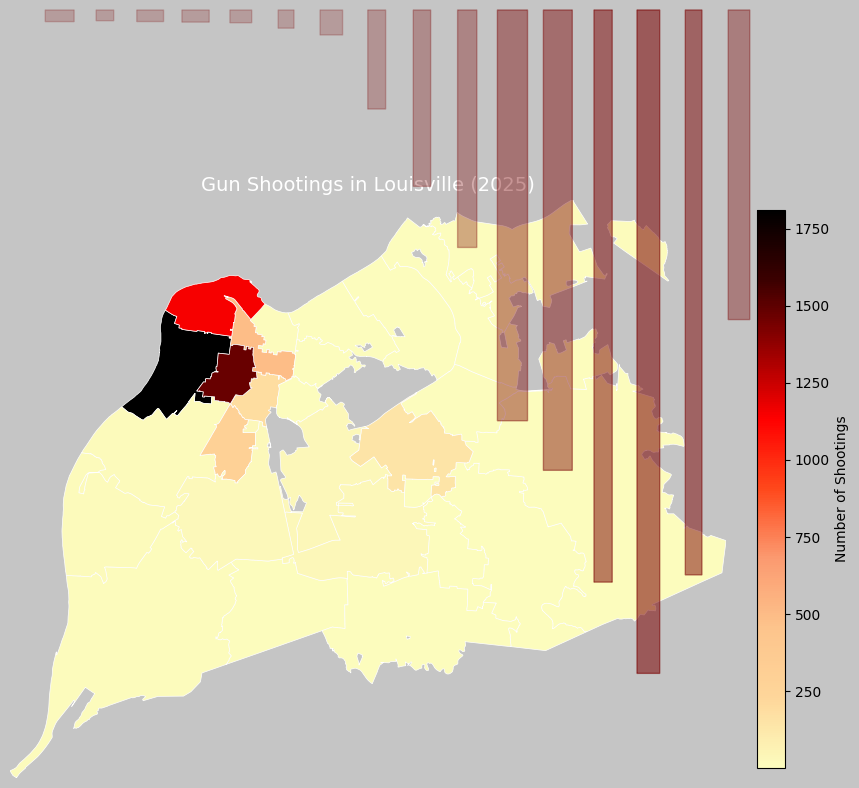

In [550]:
import pandas as pd
import pygris
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import FancyBboxPatch
import matplotlib.dates as mdates
import numpy as np

# --------------------
# PREP DATA
# --------------------
data = data.copy()
data['DateTime'] = pd.to_datetime(data['DateTime'])

# Filter to 2025
data_2025 = data.loc[data['DateTime'].dt.year == 2025].copy()
data_2025['ZIP_Code'] = data_2025['ZIP_Code'].astype(str).str.zfill(5)

# Aggregate shootings by ZIP
shootings_by_zip = (
    data_2025.groupby('ZIP_Code')['ObjectId']
    .count()
    .rename('num_shootings')
    .reset_index()
)

# Aggregate shootings by YEAR (for drips)
shootings_by_year = (
    data.groupby(data['DateTime'].dt.to_period('Y'))
    .size()
    .rename('num_shootings')
    .reset_index()
)
shootings_by_year.columns = ['Date', 'num_shootings']
shootings_by_year['Date'] = shootings_by_year['Date'].dt.to_timestamp()

# --------------------
# LOAD KY ZIP SHAPES
# --------------------
ky_zips = pygris.zctas(state="21", year=2010)
zip_col = [c for c in ky_zips.columns if 'ZCTA' in c][0]

geo_df = ky_zips.merge(
    shootings_by_zip,
    left_on=zip_col,
    right_on='ZIP_Code',
    how='left'
)
geo_df['num_shootings'] = geo_df['num_shootings'].fillna(0)
geo_df = geo_df[geo_df['ZIP_Code'].isin(data_2025['ZIP_Code'].unique())]

# --------------------
# COLOR MAP
# --------------------
colors = [
    "#000000", "#3c0000", "#990000", "#FF0000",
    "#FF481B", "#FB9A70", "#FDC48C", "#FED69A", "#FCFCBD"
][::-1]
cmap = LinearSegmentedColormap.from_list("blood", colors)

# --------------------
# FIGURE LAYOUT
# --------------------
fig = plt.figure(figsize=(10, 14))
gs = fig.add_gridspec(2, 1, height_ratios=[4, 1], hspace=0)
fig.patch.set_facecolor("#C5C5C5")

# --------------------
# MAP (TOP)
# --------------------
ax_map = fig.add_subplot(gs[0])
ax_map.set_facecolor('#C5C5C5')

geo_df.plot(
    ax=ax_map,
    column='num_shootings',
    cmap=cmap,
    edgecolor='white',
    linewidth=0.5
)

ax_map.set_title(
    "Gun Shootings in Louisville (2025)",
    fontsize=14,
    color='white'
)
ax_map.axis('off')

minx, miny, maxx, maxy = geo_df.total_bounds
ax_map.set_xlim(minx, maxx)
ax_map.set_ylim(miny, maxy)

# --------------------
# DRIPS / BARS (BOTTOM)
# --------------------
ax_drip = fig.add_subplot(gs[1])
ax_drip.set_facecolor('#C5C5C5')

max_val = shootings_by_year['num_shootings'].max()

# Draw rounded bars using FancyBboxPatch 
for _, row in shootings_by_year.iterrows(): 
    x = mdates.date2num(row['Date']) 
    width_days = np.random.randint(100, 250)
    rect = FancyBboxPatch(
    (x - width_days/2, 0),               # bottom of the bar is 0
    width=width_days,
    height=-row['num_shootings'] * 4,    # extend downward
    boxstyle="round,pad=0.0,rounding_size=10",
    color="#7a0000",
    alpha=0.2 + 0.35 * (row['num_shootings'] / max_val),
    clip_on=False
)
    
    ax_drip.add_patch(rect)

# Rounded drip tips
ax_drip.scatter(
    mdates.date2num(shootings_by_year['Date']),
    -shootings_by_year['num_shootings'],
    s=shootings_by_year['num_shootings'] * 7,
    color='#4d0000',
    alpha=0,
    zorder=3,
    clip_on=False
)

# Extend drips upward into map slightly
ax_drip.set_ylim(-max_val * 1.3, 0)
ax_drip.axis('off')

# Raise drip axis slightly to overlap map
pos = ax_drip.get_position()
ax_drip.set_position([pos.x0, pos.y0 + 0.65, pos.width, pos.height])

# Format x-axis to show years nicely (optional)
ax_drip.xaxis_date()
ax_drip.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# --- Map is already plotted on ax_map ---
sm = mpl.cm.ScalarMappable(
    cmap=cmap,
    norm=mpl.colors.Normalize(
        vmin=geo_df['num_shootings'].min(),
        vmax=geo_df['num_shootings'].max()
    )
)
sm._A = []  # required for ScalarMappable

# Attach the colorbar to the map axis
cbar = fig.colorbar(sm, ax=ax_map, fraction=0.036, pad=0.04)
cbar.set_label("Number of Shootings", fontsize=10)

# --------------------
# SHOW
# --------------------
plt.show()


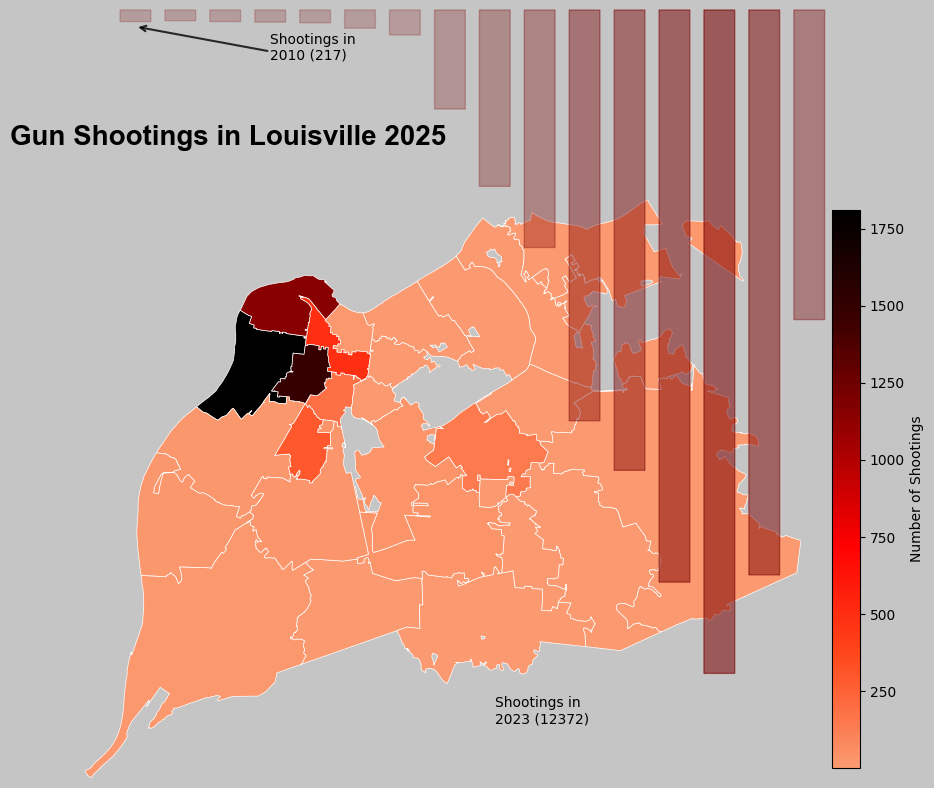

In [551]:
import pandas as pd
import pygris
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import FancyBboxPatch
import matplotlib.dates as mdates
from drawarrow import ax_arrow
import numpy as np

# --------------------
# PREP DATA
# --------------------
data = data.copy()
data['DateTime'] = pd.to_datetime(data['DateTime'])

# Filter to 2025
data_2025 = data.loc[data['DateTime'].dt.year == 2025].copy()
data_2025['ZIP_Code'] = data_2025['ZIP_Code'].astype(str).str.zfill(5)

# Aggregate shootings by ZIP
shootings_by_zip = (
    data_2025.groupby('ZIP_Code')['ObjectId']
    .count()
    .rename('num_shootings')
    .reset_index()
)

# Aggregate shootings by YEAR (for drips)
shootings_by_year = (
    data.groupby(data['DateTime'].dt.to_period('Y'))
    .size()
    .rename('num_shootings')
    .reset_index()
)
shootings_by_year.columns = ['Date', 'num_shootings']
shootings_by_year['Date'] = shootings_by_year['Date'].dt.to_timestamp()

# --------------------
# LOAD KY ZIP SHAPES
# --------------------
ky_zips = pygris.zctas(state="21", year=2010)
zip_col = [c for c in ky_zips.columns if 'ZCTA' in c][0]

geo_df = ky_zips.merge(
    shootings_by_zip,
    left_on=zip_col,
    right_on='ZIP_Code',
    how='left'
)
geo_df['num_shootings'] = geo_df['num_shootings'].fillna(0)
geo_df = geo_df[geo_df['ZIP_Code'].isin(data_2025['ZIP_Code'].unique())]

# --------------------
# COLOR MAP
# --------------------
colors = [
    "#000000", "#3c0000", "#990000", "#FF0000",
    "#FF481B", "#FB9A70",
][::-1]
cmap = LinearSegmentedColormap.from_list("blood", colors)

# --------------------
# FIGURE LAYOUT
# --------------------
fig = plt.figure(figsize=(10, 14))
gs = fig.add_gridspec(2, 1, height_ratios=[4, 1], hspace=0)
fig.patch.set_facecolor("#C5C5C5")

# --------------------
# MAP (TOP)
# --------------------
ax_map = fig.add_subplot(gs[0])
ax_map.set_facecolor('#C5C5C5')

geo_df.plot(
    ax=ax_map,
    column='num_shootings',
    cmap=cmap,
    edgecolor='white',
    linewidth=0.5
)

#  -------------------
# title
#  ___________________

ax_map.set_title(
    "Gun Shootings in Louisville 2025",
    fontsize=20,
    color='Black',
    fontweight='bold',
    fontname='Arial',
    x=0.2,
    y=1.07,
    pad=10
)
ax_map.axis('off')

minx, miny, maxx, maxy = geo_df.total_bounds
ax_map.set_xlim(minx, maxx)
ax_map.set_ylim(miny, maxy)

# --------------------
# DRIPS / BARS (BOTTOM)
# --------------------
ax_drip = fig.add_subplot(gs[1])
ax_drip.set_facecolor('#C5C5C5')

max_val = shootings_by_year['num_shootings'].max()

# Draw rounded bars using FancyBboxPatch 
for _, row in shootings_by_year.iterrows(): 
    x = mdates.date2num(row['Date']) 
    width_days = 250
    rect = FancyBboxPatch(
    (x - width_days/2, 0),               # bottom of the bar is 0
    width=width_days,
    height=-row['num_shootings'] * 4,    # extend downward
    boxstyle="round,pad=0.0,rounding_size=10",
    color="#7a0000",
    alpha=0.2 + 0.35 * (row['num_shootings'] / max_val),
    clip_on=False
)
    
    ax_drip.add_patch(rect)

# Rounded drip tips
ax_drip.scatter(
    mdates.date2num(shootings_by_year['Date']),
    -shootings_by_year['num_shootings'],
    s=shootings_by_year['num_shootings'] * 7,
    color='#4d0000',
    alpha=0,
    zorder=3,
    clip_on=False
)

# Extend drips upward into map slightly
ax_drip.set_ylim(-max_val * 1.3, 0)
ax_drip.axis('off')

# Raise drip axis slightly to overlap map
pos = ax_drip.get_position()
ax_drip.set_position([pos.x0, pos.y0 + 0.65, pos.width, pos.height])

# Format x-axis to show years nicely (optional)
ax_drip.xaxis_date()
ax_drip.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# --- Map is already plotted on ax_map ---
sm = mpl.cm.ScalarMappable(
    cmap=cmap,
    norm=mpl.colors.Normalize(
        vmin=geo_df['num_shootings'].min(),
        vmax=geo_df['num_shootings'].max()
    )
)
sm._A = []  # required for ScalarMappable

# Attach the colorbar to the map axis
cbar = fig.colorbar(sm, ax=ax_map, fraction=0.036, pad=0.04)
cbar.set_label("Number of Shootings", fontsize=10)


s = "Shootings in\n2010 (217)"

# x positions as Matplotlib numeric dates
x_text = mdates.date2num(pd.Timestamp('2013-01-01'))
x_tail = mdates.date2num(pd.Timestamp('2013-01-01'))
x_head = mdates.date2num(pd.Timestamp('2010-01-01'))

# y positions scaled to your drips
y_text = -max_val * 0.3
y_tail = -max_val * 0.25
y_head = -max_val * 0.1

# Add text
ax_drip.text(
    x=x_text,
    y=y_text,
    s=s,
    fontsize=10,
    ha='left',
    color='black'
)

# Arrow properties
arrow_props = dict(arrowstyle="->", color="black", lw=1.5, alpha=0.8)

# Add arrow
ax_drip.annotate(
    '',
    xy=(x_head, y_head),   # arrow head
    xytext=(x_tail, y_tail),  # arrow tail
    arrowprops=arrow_props
)

s = "Shootings in\n2023 (12372)"

# x positions as Matplotlib numeric dates
x_text = mdates.date2num(pd.Timestamp('2018-01-01'))
x_tail = mdates.date2num(pd.Timestamp('2020-01-01'))
x_head = mdates.date2num(pd.Timestamp('2023-01-01'))

# y positions
y_text = -max_val * 4.3      # text position above bars
y_tail = -max_val * 4.2      # arrow tail near text
y_head = -12372 * 4                   # top of the bar is always 0

# Add text
ax_drip.text(
    x=x_text,
    y=y_text,
    s=s,
    fontsize=10,
    ha='left',
    color='black'
)

# Arrow properties
arrow_props = dict(arrowstyle="->", color="black", lw=1.5, alpha=0.8)

# Add arrow pointing at top of bar
ax_drip.annotate(
    '',
    xy=(x_head, y_head),   # arrow head at top of bar
    xytext=(x_tail, y_tail),
    arrowprops=arrow_props
)





# --------------------
# SHOW
# --------------------
plt.show()


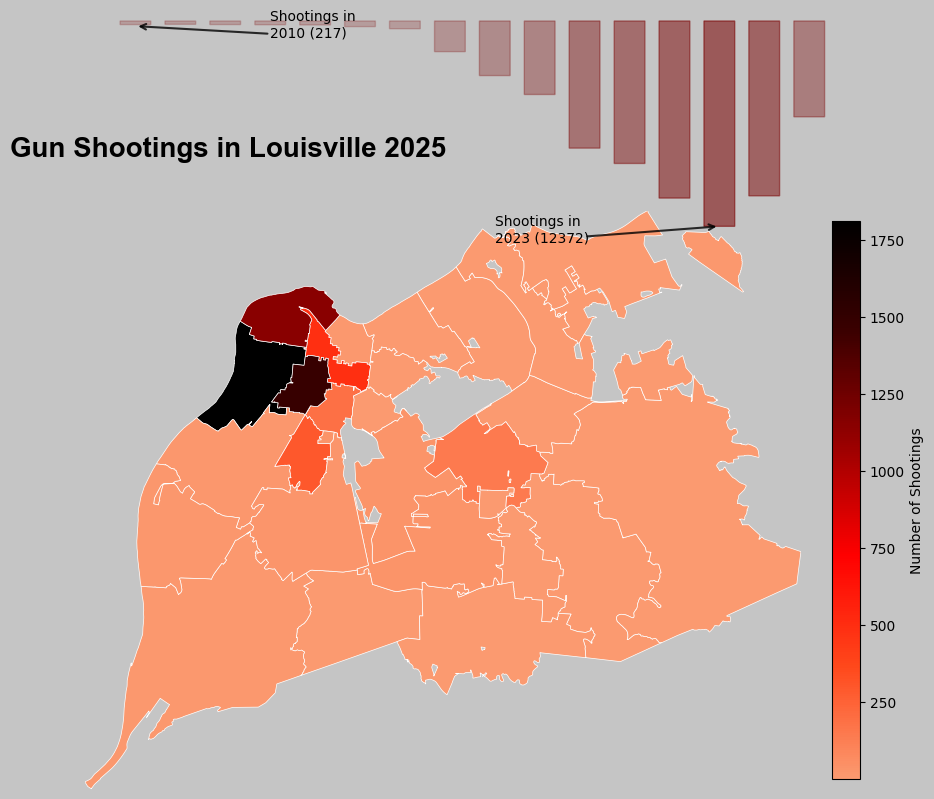

In [565]:
import pandas as pd
import pygris
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl # FIX 1: Added necessary import for mpl.cm/mpl.colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import FancyBboxPatch
import matplotlib.dates as mdates
from drawarrow import ax_arrow
import numpy as np

# --------------------
# PREP DATA
# --------------------
data = data.copy()
data['DateTime'] = pd.to_datetime(data['DateTime'])

# Filter to 2025
data_2025 = data.loc[data['DateTime'].dt.year == 2025].copy()
data_2025['ZIP_Code'] = data_2025['ZIP_Code'].astype(str).str.zfill(5)

# Aggregate shootings by ZIP
shootings_by_zip = (
    data_2025.groupby('ZIP_Code')['ObjectId']
    .count()
    .rename('num_shootings')
    .reset_index()
)

# Aggregate shootings by YEAR (for drips)
shootings_by_year = (
    data.groupby(data['DateTime'].dt.to_period('Y'))
    .size()
    .rename('num_shootings')
    .reset_index()
)
shootings_by_year.columns = ['Date', 'num_shootings']
shootings_by_year['Date'] = shootings_by_year['Date'].dt.to_timestamp()

# --------------------
# LOAD KY ZIP SHAPES
# --------------------
ky_zips = pygris.zctas(state="21", year=2010)
zip_col = [c for c in ky_zips.columns if 'ZCTA' in c][0]

geo_df = ky_zips.merge(
    shootings_by_zip,
    left_on=zip_col,
    right_on='ZIP_Code',
    how='left'
)
geo_df['num_shootings'] = geo_df['num_shootings'].fillna(0)
geo_df = geo_df[geo_df['ZIP_Code'].isin(data_2025['ZIP_Code'].unique())]

# --------------------
# COLOR MAP
# --------------------
colors = [
    "#000000", "#3c0000", "#990000", "#FF0000",
    "#FF481B", "#FB9A70",
][::-1]
cmap = LinearSegmentedColormap.from_list("blood", colors)

# --------------------
# FIGURE LAYOUT
# --------------------
fig = plt.figure(figsize=(10, 14))
gs = fig.add_gridspec(2, 1, height_ratios=[4, 1], hspace=0)
fig.patch.set_facecolor("#C5C5C5")

# --------------------
# MAP (TOP)
# --------------------
ax_map = fig.add_subplot(gs[0])
ax_map.set_facecolor('#C5C5C5')

geo_df.plot(
    ax=ax_map,
    column='num_shootings',
    cmap=cmap,
    edgecolor='white',
    linewidth=0.5
)

#  -------------------
# title
#  ___________________

ax_map.set_title(
    "Gun Shootings in Louisville 2025",
    fontsize=20,
    color='Black',
    fontweight='bold',
    fontname='Arial',
    x=0.2,
    y=1.07,
    pad=10
)
ax_map.axis('off')

minx, miny, maxx, maxy = geo_df.total_bounds
ax_map.set_xlim(minx, maxx)
ax_map.set_ylim(miny, maxy)

# --------------------
# DRIPS / BARS (BOTTOM)
# --------------------
ax_drip = fig.add_subplot(gs[1])
ax_drip.set_facecolor('#C5C5C5')

max_val = shootings_by_year['num_shootings'].max()

# Draw rounded bars using FancyBboxPatch 
for _, row in shootings_by_year.iterrows(): 
    x = mdates.date2num(row['Date']) 
    width_days = 250
    rect = FancyBboxPatch(
    (x - width_days/2, 0),               # bottom of the bar is 0
    width=width_days,
    height=-row['num_shootings'] * 4,    # extend downward
    boxstyle="round,pad=0.0,rounding_size=10",
    color="#7a0000",
    alpha=0.2 + 0.35 * (row['num_shootings'] / max_val),
    clip_on=False
)
    
    ax_drip.add_patch(rect)

# Rounded drip tips
ax_drip.scatter(
    mdates.date2num(shootings_by_year['Date']),
    -shootings_by_year['num_shootings'],
    s=shootings_by_year['num_shootings'] * 7,
    color='#4d0000',
    alpha=0,
    zorder=3,
    clip_on=False
)

# FIX 2: Corrected the Y-limit calculation to include the bottom of the longest bar (-max_val * 4)
ax_drip.set_ylim(-max_val * 4 * 1.05, 0) # Use the bar scale factor of 4

ax_drip.axis('off')

# Raise drip axis slightly to overlap map
pos = ax_drip.get_position()
ax_drip.set_position([pos.x0, pos.y0 + 0.65, pos.width, pos.height])

# Format x-axis to show years nicely (optional)
ax_drip.xaxis_date()
ax_drip.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# --- Colorbar ---
sm = mpl.cm.ScalarMappable(
    cmap=cmap,
    norm=mpl.colors.Normalize(
        vmin=geo_df['num_shootings'].min(),
        vmax=geo_df['num_shootings'].max()
    )
)
sm._A = []  # required for ScalarMappable

# Attach the colorbar to the map axis
cbar = fig.colorbar(sm, ax=ax_map, fraction=0.036, pad=0.04)
cbar.set_label("Number of Shootings", fontsize=10)


s = "Shootings in\n2010 (217)"

# x positions as Matplotlib numeric dates
x_text = mdates.date2num(pd.Timestamp('2013-01-01'))
x_tail = mdates.date2num(pd.Timestamp('2013-01-01'))
x_head = mdates.date2num(pd.Timestamp('2010-01-01'))

# y positions scaled to your drips
y_text = -max_val * 0.3
y_tail = -max_val * 0.25
y_head = -max_val * 0.1 # This position should be adjusted to the bottom of the 2010 bar, but is left as your original code

# Add text
ax_drip.text(
    x=x_text,
    y=y_text,
    s=s,
    fontsize=10,
    ha='left',
    color='black'
)

# Arrow properties
arrow_props = dict(arrowstyle="->", color="black", lw=1.5, alpha=0.8)

# Add arrow
ax_drip.annotate(
    '',
    xy=(x_head, y_head),   # arrow head
    xytext=(x_tail, y_tail),  # arrow tail
    arrowprops=arrow_props
)

s = "Shootings in\n2023 (12372)"

# x positions as Matplotlib numeric dates
x_text = mdates.date2num(pd.Timestamp('2018-01-01'))
x_tail = mdates.date2num(pd.Timestamp('2020-01-01'))
x_head = mdates.date2num(pd.Timestamp('2023-01-01'))

# y positions
y_text = -max_val * 4.3      # text position above bars
y_tail = -max_val * 4.2      # arrow tail near text
y_head = -12372 * 4          # ORIGINAL Y-HEAD VALUE RESTORED

# Add text
ax_drip.text(
    x=x_text,
    y=y_text,
    s=s,
    fontsize=10,
    ha='left',
    color='black'
)

# Arrow properties
arrow_props = dict(arrowstyle="->", color="black", lw=1.5, alpha=0.8)

# Add arrow pointing at top of bar
ax_drip.annotate(
    '',
    xy=(x_head, y_head),   # arrow head at bottom of bar (now visible)
    xytext=(x_tail, y_tail),
    arrowprops=arrow_props
)

# --------------------
# SHOW
# --------------------
plt.show()

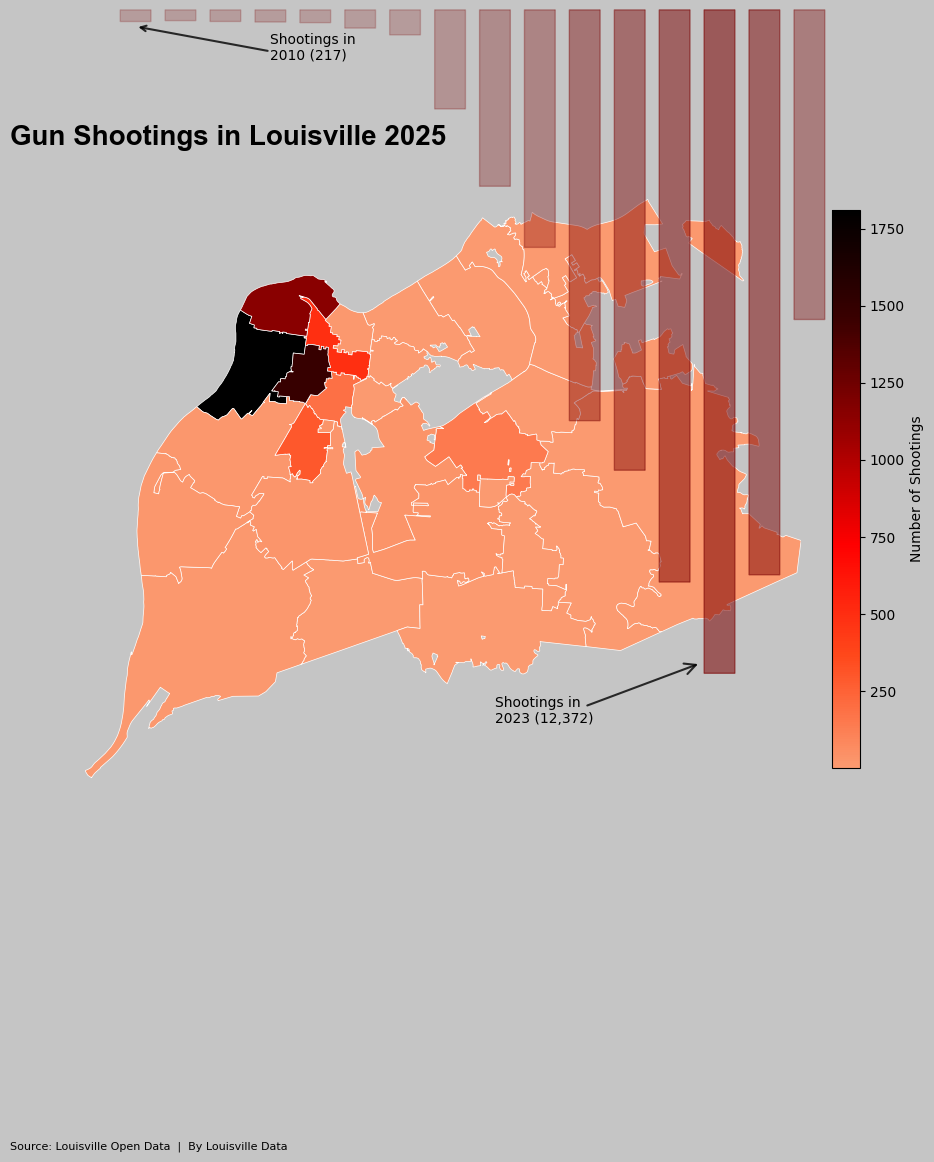

In [ ]:
import pandas as pd
import pygris
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl # <--- FIX 1: ADDED THIS FOR mpl.cm and mpl.colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import FancyBboxPatch
import matplotlib.dates as mdates
from drawarrow import ax_arrow
import numpy as np
from matplotlib.patches import FancyArrowPatch # <--- ADDED FOR FIGURE-LEVEL ARROW

# --------------------
# PREP DATA
# --------------------
data = data.copy()
data['DateTime'] = pd.to_datetime(data['DateTime'])

# Filter to 2025
data_2025 = data.loc[data['DateTime'].dt.year == 2025].copy()
data_2025['ZIP_Code'] = data_2025['ZIP_Code'].astype(str).str.zfill(5)

# Aggregate shootings by ZIP
shootings_by_zip = (
    data_2025.groupby('ZIP_Code')['ObjectId']
    .count()
    .rename('num_shootings')
    .reset_index()
)

# Aggregate shootings by YEAR (for drips)
shootings_by_year = (
    data.groupby(data['DateTime'].dt.to_period('Y'))
    .size()
    .rename('num_shootings')
    .reset_index()
)
shootings_by_year.columns = ['Date', 'num_shootings']
shootings_by_year['Date'] = shootings_by_year['Date'].dt.to_timestamp()

# --------------------
# LOAD KY ZIP SHAPES
# --------------------
ky_zips = pygris.zctas(state="21", year=2010)
zip_col = [c for c in ky_zips.columns if 'ZCTA' in c][0]

geo_df = ky_zips.merge(
    shootings_by_zip,
    left_on=zip_col,
    right_on='ZIP_Code',
    how='left'
)
geo_df['num_shootings'] = geo_df['num_shootings'].fillna(0)
geo_df = geo_df[geo_df['ZIP_Code'].isin(data_2025['ZIP_Code'].unique())]

# --------------------
# COLOR MAP
# --------------------
colors = [
    "#000000", "#3c0000", "#990000", "#FF0000",
    "#FF481B", "#FB9A70",
][::-1]
cmap = LinearSegmentedColormap.from_list("blood", colors)

# --------------------
# FIGURE LAYOUT
# --------------------
fig = plt.figure(figsize=(10, 14))
gs = fig.add_gridspec(2, 1, height_ratios=[4, 1], hspace=0)
fig.patch.set_facecolor("#C5C5C5")

# --------------------
# MAP (TOP)
# --------------------
ax_map = fig.add_subplot(gs[0])
ax_map.set_facecolor('#C5C5C5')

geo_df.plot(
    ax=ax_map,
    column='num_shootings',
    cmap=cmap,
    edgecolor='white',
    linewidth=0.5
)

#  -------------------
# title
#  ___________________

ax_map.set_title(
    "Gun Shootings in Louisville 2025",
    fontsize=20,
    color='Black',
    fontweight='bold',
    fontname='Arial',
    x=0.2,
    y=1.07,
    pad=10
)
ax_map.axis('off')

minx, miny, maxx, maxy = geo_df.total_bounds
ax_map.set_xlim(minx, maxx)
ax_map.set_ylim(miny, maxy)

# --------------------
# DRIPS / BARS (BOTTOM)
# --------------------
ax_drip = fig.add_subplot(gs[1])
ax_drip.set_facecolor('#C5C5C5')

max_val = shootings_by_year['num_shootings'].max()

# Draw rounded bars using FancyBboxPatch (YOUR ORIGINAL CODE)
for _, row in shootings_by_year.iterrows(): 
    x = mdates.date2num(row['Date']) 
    width_days = 250
    rect = FancyBboxPatch(
    (x - width_days/2, 0),               # bottom of the bar is 0
    width=width_days,
    height=-row['num_shootings'] * 4,    # extend downward
    boxstyle="round,pad=0.0,rounding_size=10",
    color="#7a0000",
    alpha=0.2 + 0.35 * (row['num_shootings'] / max_val),
    clip_on=False
)
    
    ax_drip.add_patch(rect)

# Rounded drip tips (YOUR ORIGINAL CODE)
ax_drip.scatter(
    mdates.date2num(shootings_by_year['Date']),
    -shootings_by_year['num_shootings'],
    s=shootings_by_year['num_shootings'] * 7,
    color='#4d0000',
    alpha=0,
    zorder=3,
    clip_on=False
)

# Extend drips upward into map slightly (YOUR ORIGINAL CODE)
ax_drip.set_ylim(-max_val * 1.3, 0)
ax_drip.axis('off')

# Raise drip axis slightly to overlap map (YOUR ORIGINAL CODE)
pos = ax_drip.get_position()
ax_drip.set_position([pos.x0, pos.y0 + 0.65, pos.width, pos.height])

# Format x-axis to show years nicely (optional)
ax_drip.xaxis_date()
ax_drip.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# --- Map is already plotted on ax_map ---
sm = mpl.cm.ScalarMappable(
    cmap=cmap,
    norm=mpl.colors.Normalize(
        vmin=geo_df['num_shootings'].min(),
        vmax=geo_df['num_shootings'].max()
    )
)
sm._A = []  # required for ScalarMappable

# Attach the colorbar to the map axis
cbar = fig.colorbar(sm, ax=ax_map, fraction=0.036, pad=0.04)
cbar.set_label("Number of Shootings", fontsize=10)


s = "Shootings in\n2010 (217)"

# x positions as Matplotlib numeric dates
x_text = mdates.date2num(pd.Timestamp('2013-01-01'))
x_tail = mdates.date2num(pd.Timestamp('2013-01-01'))
x_head = mdates.date2num(pd.Timestamp('2010-01-01'))

# y positions scaled to your drips
y_text = -max_val * 0.3
y_tail = -max_val * 0.25
y_head = -max_val * 0.1

# Add text
ax_drip.text(
    x=x_text,
    y=y_text,
    s=s,
    fontsize=10,
    ha='left',
    color='black'
)

# Arrow properties
arrow_props = dict(arrowstyle="->", color="black", lw=1.5, alpha=0.8)

# Add arrow
ax_drip.annotate(
    '',
    xy=(x_head, y_head),
    xytext=(x_tail, y_tail),
    arrowprops=arrow_props
)

s = "Shootings in\n2023 (12,372)"

# x positions as Matplotlib numeric dates
x_text = mdates.date2num(pd.Timestamp('2018-01-01'))
x_tail = mdates.date2num(pd.Timestamp('2020-01-01'))
x_head = mdates.date2num(pd.Timestamp('2022-08-01'))

# y positions 
y_text = -max_val * 4.3
y_tail = -max_val * 4.2
y_head = -12182 * 4

# Add text 
ax_drip.text(
    x=x_text,
    y=y_text,
    s=s,
    fontsize=10,
    ha='left',
    color='black'
)

# Arrow properties 
arrow_props = dict(arrowstyle="simple", color="black", lw=1.5, alpha=0.8, mutation_scale=10)

arrow = FancyArrowPatch(
    posA=(x_tail, y_tail),
    posB=(x_head, y_head),
    arrowstyle="->",
    color="black",
    lw=1.5,
    alpha=0.8,
    mutation_scale=20, 
    transform=ax_drip.transData,
    clip_on=False
)

# Add the arrow to the Figure artists
fig.add_artist(arrow)

fig.text(
    x=0.05,
    y=0.1,
    s="Source: Louisville Open Data  |  By Louisville Data",
    fontsize=8,
    color='black',
    ha='left',
    transform=fig.transFigure
)

# --------------------
# SHOW
# --------------------
plt.show()

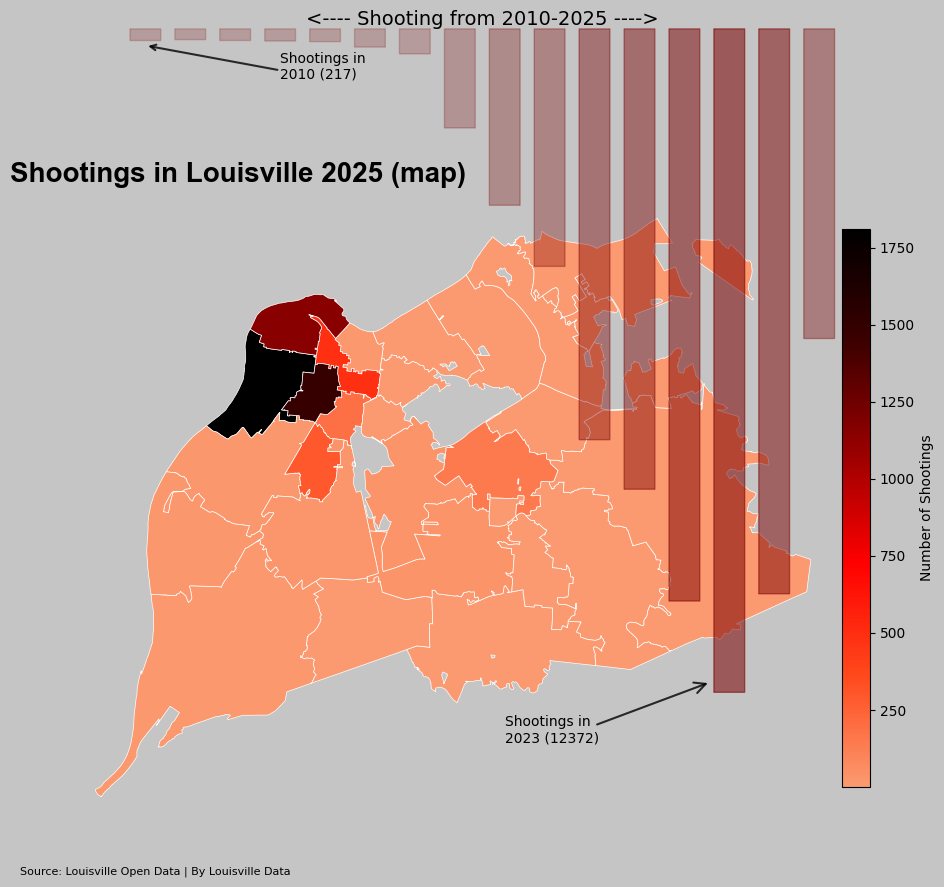

In [569]:
import pandas as pd
import pygris
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl 
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import FancyBboxPatch
import matplotlib.dates as mdates
from drawarrow import ax_arrow
import numpy as np
from matplotlib.patches import FancyArrowPatch 

# --------------------
# PREP DATA
# --------------------
data = data.copy()
data['DateTime'] = pd.to_datetime(data['DateTime'])

# Filter to 2025
data_2025 = data.loc[data['DateTime'].dt.year == 2025].copy()
data_2025['ZIP_Code'] = data_2025['ZIP_Code'].astype(str).str.zfill(5)

# Aggregate shootings by ZIP
shootings_by_zip = (
    data_2025.groupby('ZIP_Code')['ObjectId']
    .count()
    .rename('num_shootings')
    .reset_index()
)

# Aggregate shootings by YEAR (for drips)
shootings_by_year = (
    data.groupby(data['DateTime'].dt.to_period('Y'))
    .size()
    .rename('num_shootings')
    .reset_index()
)
shootings_by_year.columns = ['Date', 'num_shootings']
shootings_by_year['Date'] = shootings_by_year['Date'].dt.to_timestamp()

# --------------------
# LOAD KY ZIP SHAPES
# --------------------
ky_zips = pygris.zctas(state="21", year=2010)
zip_col = [c for c in ky_zips.columns if 'ZCTA' in c][0]

geo_df = ky_zips.merge(
    shootings_by_zip,
    left_on=zip_col,
    right_on='ZIP_Code',
    how='left'
)
geo_df['num_shootings'] = geo_df['num_shootings'].fillna(0)
geo_df = geo_df[geo_df['ZIP_Code'].isin(data_2025['ZIP_Code'].unique())]

# --------------------
# COLOR MAP
# --------------------
colors = [
    "#000000", "#3c0000", "#990000", "#FF0000",
    "#FF481B", "#FB9A70",
][::-1]
cmap = LinearSegmentedColormap.from_list("blood", colors)

# --------------------
# FIGURE LAYOUT
# --------------------
fig = plt.figure(figsize=(10, 14))
gs = fig.add_gridspec(2, 1, height_ratios=[4, 1], hspace=0)
fig.patch.set_facecolor("#C5C5C5")

# --------------------
# MAP (TOP)
# --------------------
ax_map = fig.add_subplot(gs[0])
ax_map.set_facecolor('#C5C5C5')

geo_df.plot(
    ax=ax_map,
    column='num_shootings',
    cmap=cmap,
    edgecolor='white',
    linewidth=0.5
)

#  -------------------
# title
#  ___________________

ax_map.set_title(
    "Shootings in Louisville 2025 (map)",
    fontsize=20,
    color='Black',
    fontweight='bold',
    fontname='Arial',
    x=0.2,
    y=1.04,
    pad=10
)
ax_map.axis('off')

minx, miny, maxx, maxy = geo_df.total_bounds
ax_map.set_xlim(minx, maxx)
ax_map.set_ylim(miny, maxy)

# --------------------
# DRIPS / BARS (BOTTOM)
# --------------------
ax_drip = fig.add_subplot(gs[1])
ax_drip.set_facecolor('#C5C5C5')

max_val = shootings_by_year['num_shootings'].max()

# Draw rounded bars using FancyBboxPatch 
for _, row in shootings_by_year.iterrows(): 
    x = mdates.date2num(row['Date']) 
    width_days = 250
    rect = FancyBboxPatch(
    (x - width_days/2, 0),               # bottom of the bar is 0
    width=width_days,
    height=-row['num_shootings'] * 4,    # extend downward
    boxstyle="round,pad=0.0,rounding_size=10",
    color="#7a0000",
    alpha=0.2 + 0.35 * (row['num_shootings'] / max_val),
    clip_on=False
)
    
    ax_drip.add_patch(rect)

# Rounded drip tips
ax_drip.scatter(
    mdates.date2num(shootings_by_year['Date']),
    -shootings_by_year['num_shootings'],
    s=shootings_by_year['num_shootings'] * 7,
    color='#4d0000',
    alpha=0,
    zorder=3,
    clip_on=False
)

# Extend drips upward into map slightly (YOUR ORIGINAL CODE)
ax_drip.set_ylim(-max_val * 1.3, 0)
ax_drip.axis('off')

# Raise drip axis slightly to overlap map
pos = ax_drip.get_position()
ax_drip.set_position([pos.x0, pos.y0 + 0.65, pos.width, pos.height])

# Format x-axis to show years nicely (optional)
ax_drip.xaxis_date()
ax_drip.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add "Shooting from 2010-2025" above the bars
ax_drip.text(
    x=0.5,
    y=1,
    s="<---- Shooting from 2010-2025 ---->",
    fontsize=14,
    color='black',
    ha='center',
    va='bottom',
    transform=ax_drip.transAxes
)

# --- Map is already plotted on ax_map ---
sm = mpl.cm.ScalarMappable(
    cmap=cmap,
    norm=mpl.colors.Normalize(
        vmin=geo_df['num_shootings'].min(),
        vmax=geo_df['num_shootings'].max()
    )
)
sm._A = []

# Attach the colorbar to the map axis
cbar = fig.colorbar(sm, ax=ax_map, fraction=0.036, pad=0.04)
cbar.set_label("Number of Shootings", fontsize=10)


s = "Shootings in\n2010 (217)"

# x positions as Matplotlib numeric dates
x_text = mdates.date2num(pd.Timestamp('2013-01-01'))
x_tail = mdates.date2num(pd.Timestamp('2013-01-01'))
x_head = mdates.date2num(pd.Timestamp('2010-01-01'))

# y positions scaled to your drips
y_text = -max_val * 0.3
y_tail = -max_val * 0.25
y_head = -max_val * 0.1

# Add text
ax_drip.text(
    x=x_text,
    y=y_text,
    s=s,
    fontsize=10,
    ha='left',
    color='black'
)

# Arrow properties
arrow_props = dict(arrowstyle="->", color="black", lw=1.5, alpha=0.8)

# Add arrow
ax_drip.annotate(
    '',
    xy=(x_head, y_head),
    xytext=(x_tail, y_tail),
    arrowprops=arrow_props
)

s = "Shootings in\n2023 (12372)"

# x positions as Matplotlib numeric dates
x_text = mdates.date2num(pd.Timestamp('2018-01-01'))
x_tail = mdates.date2num(pd.Timestamp('2020-01-01'))
x_head = mdates.date2num(pd.Timestamp('2022-08-01'))

# y positions
y_text = -max_val * 4.3
y_tail = -max_val * 4.2
y_head = -12182 * 4

ax_drip.text(
    x=x_text,
    y=y_text,
    s=s,
    fontsize=10,
    ha='left',
    color='black'
)

# Arrow properties
arrow_props = dict(arrowstyle="simple", color="black", lw=1.5, alpha=0.8, mutation_scale=10) 

# Draw the arrow using FancyArrowPatch and the ax_drip transform (to bypass clipping)
arrow = FancyArrowPatch(
    posA=(x_tail, y_tail),
    posB=(x_head, y_head),
    arrowstyle="->",
    color="black",
    lw=1.5,
    alpha=0.8,
    mutation_scale=20, 
    transform=ax_drip.transData,
    clip_on=False
)

# Add the arrow to the Figure artists
fig.add_artist(arrow)

# *** SOURCE FIX: Adjusted Y coordinate to move it closer to the plots ***
fig.text(
    x=0.05,
    y=.31, 
    s="Source: Louisville Open Data | By Louisville Data",
    fontsize=8,
    color='black',
    ha='left',
    transform=fig.transFigure 
)

# --------------------
# SHOW
# --------------------
plt.show()

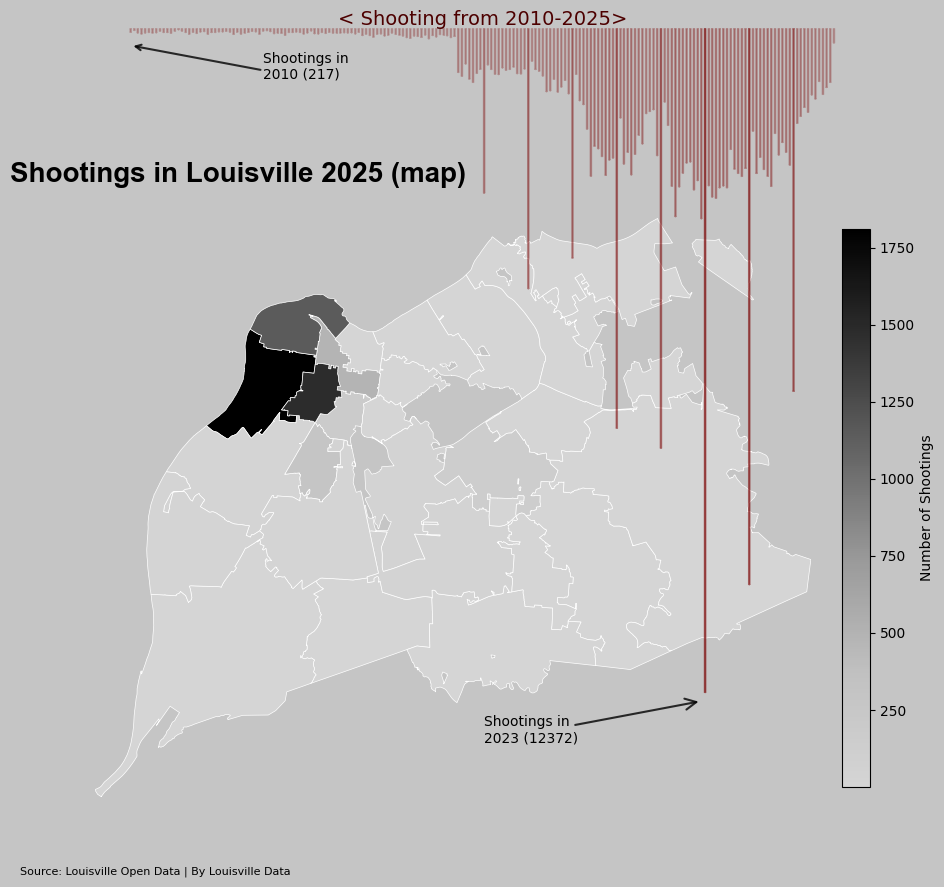

In [592]:
import pandas as pd
import pygris
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl 
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import FancyBboxPatch
import matplotlib.dates as mdates
from drawarrow import ax_arrow
import numpy as np
from matplotlib.patches import FancyArrowPatch 

# --------------------
# PREP DATA
# --------------------
data = data.copy()
data['DateTime'] = pd.to_datetime(data['DateTime'])

# Filter to 2025
data_2025 = data.loc[data['DateTime'].dt.year == 2025].copy()
data_2025['ZIP_Code'] = data_2025['ZIP_Code'].astype(str).str.zfill(5)

# Aggregate shootings by ZIP
shootings_by_zip = (
    data_2025.groupby('ZIP_Code')['ObjectId']
    .count()
    .rename('num_shootings')
    .reset_index()
)

# Aggregate shootings by YEAR (for drips)
shootings_by_year = (
    data.groupby(data['DateTime'].dt.to_period('M'))
    .size()
    .rename('num_shootings')
    .reset_index()
)
shootings_by_year.columns = ['Date', 'num_shootings']
shootings_by_year['Date'] = shootings_by_year['Date'].dt.to_timestamp()

# --------------------
# LOAD KY ZIP SHAPES
# --------------------
ky_zips = pygris.zctas(state="21", year=2010)
zip_col = [c for c in ky_zips.columns if 'ZCTA' in c][0]

geo_df = ky_zips.merge(
    shootings_by_zip,
    left_on=zip_col,
    right_on='ZIP_Code',
    how='left'
)
geo_df['num_shootings'] = geo_df['num_shootings'].fillna(0)
geo_df = geo_df[geo_df['ZIP_Code'].isin(data_2025['ZIP_Code'].unique())]

# --------------------
# COLOR MAP
# --------------------
colors = [
    "#000000", "#303030", "#646464", "#9B9B9B",
    "#C1C1C1", "#D5D5D5",
][::-1]
cmap = LinearSegmentedColormap.from_list("blood", colors)

# --------------------
# FIGURE LAYOUT
# --------------------
fig = plt.figure(figsize=(10, 14))
gs = fig.add_gridspec(2, 1, height_ratios=[4, 1], hspace=0)
fig.patch.set_facecolor("#C5C5C5")

# --------------------
# MAP (TOP)
# --------------------
ax_map = fig.add_subplot(gs[0])
ax_map.set_facecolor('#C5C5C5')

geo_df.plot(
    ax=ax_map,
    column='num_shootings',
    cmap=cmap,
    edgecolor='white',
    linewidth=0.5
)

#  -------------------
# title
#  ___________________

ax_map.set_title(
    "Shootings in Louisville 2025 (map)",
    fontsize=20,
    color='Black',
    fontweight='bold',
    fontname='Arial',
    x=0.2,
    y=1.04,
    pad=10
)
ax_map.axis('off')

minx, miny, maxx, maxy = geo_df.total_bounds
ax_map.set_xlim(minx, maxx)
ax_map.set_ylim(miny, maxy)

# --------------------
# DRIPS / BARS (BOTTOM)
# --------------------
ax_drip = fig.add_subplot(gs[1])
ax_drip.set_facecolor('#C5C5C5')

max_val = shootings_by_year['num_shootings'].max()

# Draw rounded bars using FancyBboxPatch 
for _, row in shootings_by_year.iterrows(): 
    x = mdates.date2num(row['Date']) 
    width_days = 10
    rect = FancyBboxPatch(
    (x - width_days/2, 0),               # bottom of the bar is 0
    width=width_days,
    height=-row['num_shootings'] * 4,    # extend downward
    boxstyle="round,pad=0.0,rounding_size=10",
    color="#7a0000",
    alpha=0.2 + 0.35 * (row['num_shootings'] / max_val),
    clip_on=False
)
    
    ax_drip.add_patch(rect)

# Rounded drip tips
ax_drip.scatter(
    mdates.date2num(shootings_by_year['Date']),
    -shootings_by_year['num_shootings'],
    s=shootings_by_year['num_shootings'] * 7,
    color='#4d0000',
    alpha=0,
    zorder=3,
    clip_on=False
)

# Extend drips upward into map slightly (YOUR ORIGINAL CODE)
ax_drip.set_ylim(-max_val * 1.3, 0)
ax_drip.axis('off')

# Raise drip axis slightly to overlap map
pos = ax_drip.get_position()
ax_drip.set_position([pos.x0, pos.y0 + 0.65, pos.width, pos.height])

# Format x-axis to show years nicely (optional)
ax_drip.xaxis_date()
ax_drip.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add "Shooting from 2010-2025" above the bars
ax_drip.text(
    x=0.5,
    y=1,
    s="< Shooting from 2010-2025>",
    fontsize=14,
    color='#4d0000',
    ha='center',
    va='bottom',
    transform=ax_drip.transAxes
)

# --- Map is already plotted on ax_map ---
sm = mpl.cm.ScalarMappable(
    cmap=cmap,
    norm=mpl.colors.Normalize(
        vmin=geo_df['num_shootings'].min(),
        vmax=geo_df['num_shootings'].max()
    )
)
sm._A = []

# Attach the colorbar to the map axis
cbar = fig.colorbar(sm, ax=ax_map, fraction=0.036, pad=0.04)
cbar.set_label("Number of Shootings", fontsize=10)


s = "Shootings in\n2010 (217)"

# x positions as Matplotlib numeric dates
x_text = mdates.date2num(pd.Timestamp('2013-01-01'))
x_tail = mdates.date2num(pd.Timestamp('2013-01-01'))
x_head = mdates.date2num(pd.Timestamp('2010-01-01'))

# y positions scaled to your drips
y_text = -max_val * 0.3
y_tail = -max_val * 0.25
y_head = -max_val * 0.1

# Add text
ax_drip.text(
    x=x_text,
    y=y_text,
    s=s,
    fontsize=10,
    ha='left',
    color='black'
)

# Arrow properties
arrow_props = dict(arrowstyle="->", color="black", lw=1.5, alpha=0.8)

# Add arrow
ax_drip.annotate(
    '',
    xy=(x_head, y_head),
    xytext=(x_tail, y_tail),
    arrowprops=arrow_props
)

s = "Shootings in\n2023 (12372)"

# x positions as Matplotlib numeric dates
x_text = mdates.date2num(pd.Timestamp('2018-01-01'))
x_tail = mdates.date2num(pd.Timestamp('2020-01-01'))
x_head = mdates.date2num(pd.Timestamp('2022-12-01'))

# y positions
y_text = -max_val * 4.3
y_tail = -max_val * 4.2
y_head = -3582 * 4

ax_drip.text(
    x=x_text,
    y=y_text,
    s=s,
    fontsize=10,
    ha='left',
    color='black'
)

# Arrow properties
arrow_props = dict(arrowstyle="simple", color="black", lw=1.5, alpha=0.8, mutation_scale=10) 

# Draw the arrow using FancyArrowPatch and the ax_drip transform (to bypass clipping)
arrow = FancyArrowPatch(
    posA=(x_tail, y_tail),
    posB=(x_head, y_head),
    arrowstyle="->",
    color="black",
    lw=1.5,
    alpha=0.8,
    mutation_scale=20, 
    transform=ax_drip.transData,
    clip_on=False
)

# Add the arrow to the Figure artists
fig.add_artist(arrow)

# *** SOURCE FIX: Adjusted Y coordinate to move it closer to the plots ***
fig.text(
    x=0.05,
    y=.31, 
    s="Source: Louisville Open Data | By Louisville Data",
    fontsize=8,
    color='black',
    ha='left',
    transform=fig.transFigure 
)

# --------------------
# SHOW
# --------------------
plt.show()

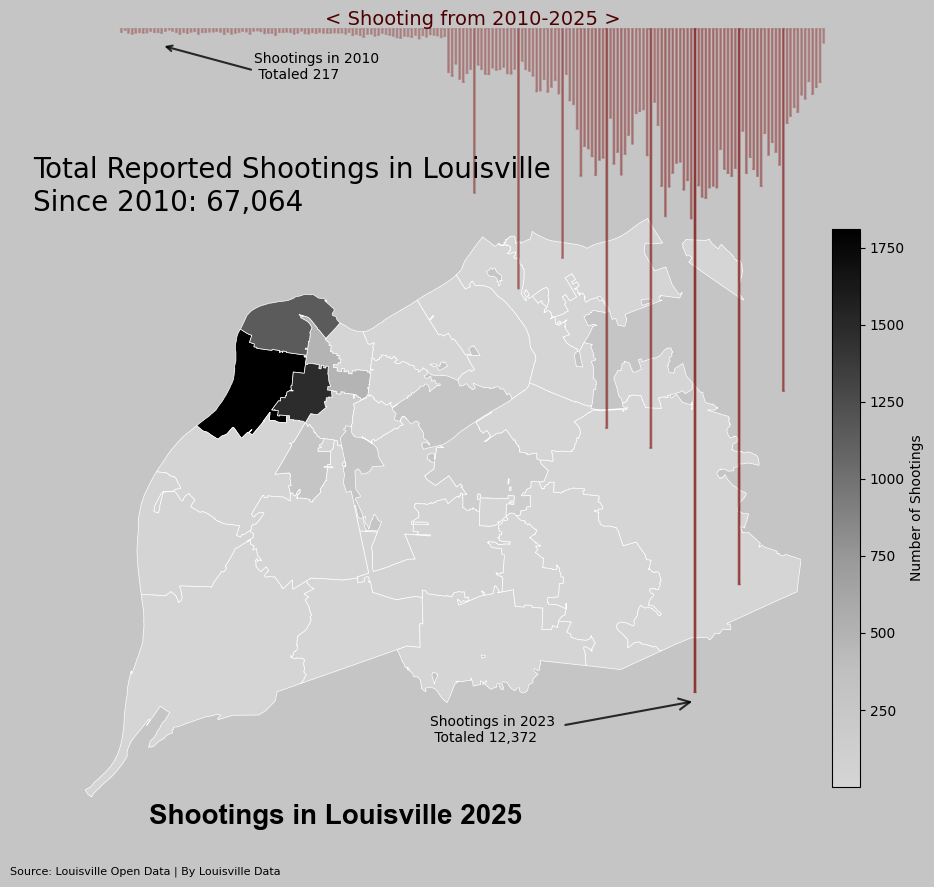

In [618]:
import pandas as pd
import pygris
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl 
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import FancyBboxPatch
import matplotlib.dates as mdates
from drawarrow import ax_arrow
import numpy as np
from matplotlib.patches import FancyArrowPatch 

# --------------------
# PREP DATA
# --------------------
data = data.copy()
data['DateTime'] = pd.to_datetime(data['DateTime'])

# Filter to 2025
data_2025 = data.loc[data['DateTime'].dt.year == 2025].copy()
data_2025['ZIP_Code'] = data_2025['ZIP_Code'].astype(str).str.zfill(5)

# Aggregate shootings by ZIP
shootings_by_zip = (
    data_2025.groupby('ZIP_Code')['ObjectId']
    .count()
    .rename('num_shootings')
    .reset_index()
)

# Aggregate shootings by YEAR (for drips)
shootings_by_year = (
    data.groupby(data['DateTime'].dt.to_period('M'))
    .size()
    .rename('num_shootings')
    .reset_index()
)
shootings_by_year.columns = ['Date', 'num_shootings']
shootings_by_year['Date'] = shootings_by_year['Date'].dt.to_timestamp()

# --------------------
# LOAD KY ZIP SHAPES
# --------------------
ky_zips = pygris.zctas(state="21", year=2010)
zip_col = [c for c in ky_zips.columns if 'ZCTA' in c][0]

geo_df = ky_zips.merge(
    shootings_by_zip,
    left_on=zip_col,
    right_on='ZIP_Code',
    how='left'
)
geo_df['num_shootings'] = geo_df['num_shootings'].fillna(0)
geo_df = geo_df[geo_df['ZIP_Code'].isin(data_2025['ZIP_Code'].unique())]

# --------------------
# COLOR MAP
# --------------------
colors = [
    "#000000", "#303030", "#646464", "#9B9B9B",
    "#C1C1C1", "#D5D5D5",
][::-1]
cmap = LinearSegmentedColormap.from_list("blood", colors)

# --------------------
# FIGURE LAYOUT
# --------------------
fig = plt.figure(figsize=(10, 14))
gs = fig.add_gridspec(2, 1, height_ratios=[4, 1], hspace=0)
fig.patch.set_facecolor("#C5C5C5")

# --------------------
# MAP (TOP)
# --------------------
ax_map = fig.add_subplot(gs[0])
ax_map.set_facecolor('#C5C5C5')

geo_df.plot(
    ax=ax_map,
    column='num_shootings',
    cmap=cmap,
    edgecolor='white',
    linewidth=0.5
)

#  -------------------
# title
#  ___________________

ax_map.set_title(
    "Shootings in Louisville 2025",
    fontsize=20,
    color='Black',
    fontweight='bold',
    fontname='Arial',
    x=0.35,
    y=-.07,
    pad=10
)
ax_map.axis('off')

minx, miny, maxx, maxy = geo_df.total_bounds
ax_map.set_xlim(minx, maxx)
ax_map.set_ylim(miny, maxy)

# --------------------
# DRIPS / BARS (BOTTOM)
# --------------------
ax_drip = fig.add_subplot(gs[1])
ax_drip.set_facecolor('#C5C5C5')

max_val = shootings_by_year['num_shootings'].max()

# Draw rounded bars using FancyBboxPatch 
for _, row in shootings_by_year.iterrows(): 
    x = mdates.date2num(row['Date']) 
    width_days = 10
    rect = FancyBboxPatch(
    (x - width_days/2, 0),               # bottom of the bar is 0
    width=width_days,
    height=-row['num_shootings'] * 4,    # extend downward
    boxstyle="round,pad=1.0,rounding_size=15",
    color="#7a0000",
    alpha=0.2 + 0.35 * (row['num_shootings'] / max_val),
    clip_on=False
)
    
    ax_drip.add_patch(rect)

# Rounded drip tips
ax_drip.scatter(
    mdates.date2num(shootings_by_year['Date']),
    -shootings_by_year['num_shootings'],
    s=shootings_by_year['num_shootings'] * 7,
    color='#4d0000',
    alpha=0,
    zorder=3,
    clip_on=False
)

# Extend drips upward into map slightly
ax_drip.set_ylim(-max_val * 1.3, 0)
ax_drip.axis('off')

# Raise drip axis slightly to overlap map
pos = ax_drip.get_position()
ax_drip.set_position([pos.x0, pos.y0 + 0.65, pos.width, pos.height])

# Format x-axis to show years nicely (optional)
ax_drip.xaxis_date()
ax_drip.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add "Shooting from 2010-2025" above the bars
ax_drip.text(
    x=0.5,
    y=1,
    s="< Shooting from 2010-2025 >",
    fontsize=14,
    color='#4d0000',
    ha='center',
    va='bottom',
    transform=ax_drip.transAxes
)

# --- Map is already plotted on ax_map ---
sm = mpl.cm.ScalarMappable(
    cmap=cmap,
    norm=mpl.colors.Normalize(
        vmin=geo_df['num_shootings'].min(),
        vmax=geo_df['num_shootings'].max()
    )
)
sm._A = []

# Attach the colorbar to the map axis
cbar = fig.colorbar(sm, ax=ax_map, fraction=0.036, pad=0.04)
cbar.set_label("Number of Shootings", fontsize=10)


s = "Shootings in 2010\n Totaled 217"

# x positions as Matplotlib numeric dates
x_text = mdates.date2num(pd.Timestamp('2013-01-01'))
x_tail = mdates.date2num(pd.Timestamp('2013-01-01'))
x_head = mdates.date2num(pd.Timestamp('2010-12-01'))

# y positions scaled to your drips
y_text = -max_val * 0.3
y_tail = -max_val * 0.25
y_head = -max_val * 0.1

# Add text
ax_drip.text(
    x=x_text,
    y=y_text,
    s=s,
    fontsize=10,
    ha='left',
    color='black'
)

# Arrow properties
arrow_props = dict(arrowstyle="->", color="black", lw=1.5, alpha=0.8)

# Add arrow
ax_drip.annotate(
    '',
    xy=(x_head, y_head),
    xytext=(x_tail, y_tail),
    arrowprops=arrow_props
)

s = "Shootings in 2023\n Totaled 12,372"

# x positions as Matplotlib numeric dates
x_text = mdates.date2num(pd.Timestamp('2017-01-01'))
x_tail = mdates.date2num(pd.Timestamp('2020-01-01'))
x_head = mdates.date2num(pd.Timestamp('2023-01-01'))

# y positions
y_text = -max_val * 4.3
y_tail = -max_val * 4.2
y_head = -3582 * 4

ax_drip.text(
    x=x_text,
    y=y_text,
    s=s,
    fontsize=10,
    ha='left',
    color='black'
)

s = "Total Reported Shootings in Louisville\nSince 2010: 67,064"

# x positions as Matplotlib numeric dates
x_text = mdates.date2num(pd.Timestamp('2008-01-01'))


# y positions
y_text = -900 * 4.3


ax_drip.text(
    x=x_text,
    y=y_text,
    s=s,
    fontsize=20,
    ha='left',
    color='black'
)

# Arrow properties
arrow_props = dict(arrowstyle="simple", color="black", lw=1.5, alpha=0.8, mutation_scale=10) 

# Draw the arrow using FancyArrowPatch and the ax_drip transform (to bypass clipping)
arrow = FancyArrowPatch(
    posA=(x_tail, y_tail),
    posB=(x_head, y_head),
    arrowstyle="->",
    color="black",
    lw=1.5,
    alpha=0.8,
    mutation_scale=20, 
    transform=ax_drip.transData,
    clip_on=False
)

# Add the arrow to the Figure artists
fig.add_artist(arrow)

# *** SOURCE FIX: Adjusted Y coordinate to move it closer to the plots ***
fig.text(
    x=0.05,
    y=.31, 
    s="Source: Louisville Open Data | By Louisville Data",
    fontsize=8,
    color='black',
    ha='left',
    transform=fig.transFigure 
)

# --------------------
# SHOW
# --------------------
plt.show()

In [607]:
data.head()

,Case_Number,DateTime,Address,Neighborhood,Council_District,Latitude,Longitude,ZIP_Code,Crime_Type,Cause,Sex,Race,Age_Group,Division_Name,ObjectId,Date
0,8010097010,2010-12-08,"N 33rd St @ Bank St, Louisville, Ky",Portland,5,38.272650,-85.800687,40212,Non-Fatal Shooting,Gun Shot Wound,Male,White,25-34,First,1,2010-12-08
1,8010097306,2010-12-09,"Dixie Hwy @ W Gaulbert Ave, Louisville, Ky",Algonquin,6,38.227553,-85.790800,40210,Homicide,Gun Shot Wound,Male,Black,18-24,Second,2,2010-12-09
2,8010097982,2010-12-11,"1700 Block Of Patton Ct, Louisville, Ky",Algonquin,6,38.224834,-85.778739,40210,Non-Fatal Shooting,Gun Shot Wound,Male,Black,18-24,Second,3,2010-12-11
3,8010098167,2010-12-12,"S 30th St @ W Muhammad Ali Blvd, Louisville, Ky",Russell,5,38.255901,-85.800531,40212,Homicide,Gun Shot Wound,Male,Black,25-34,First,4,2010-12-12
4,8010099052,2010-12-15,"3600 Block Of Manslick Rd, Louisville, Ky",Jacobs,3,38.195354,-85.799650,40215,Homicide,Blunt Force Trauma,Male,White,1-10,Fourth,5,2010-12-15


In [608]:
data.shape

(67064, 16)

In [628]:
shootings_by_year = (
    data.groupby(data['DateTime'].dt.to_period('M'))
    .size()
    .rename('num_shootings')
    .reset_index()
)
shootings_by_year.columns = ['Date', 'num_shootings']
shootings_by_year['Date'] = shootings_by_year['Date'].dt.to_timestamp()
shootings_by_year = shootings_by_year.sort_values('num_shootings', ascending=False)
shootings_by_year.head(15)

,Date,num_shootings
156,2023-01-01,3535
168,2024-01-01,2960
144,2022-01-01,2233
132,2021-01-01,2127
180,2025-01-01,1930
108,2019-01-01,1383
120,2020-01-01,1220
155,2022-12-01,1010
148,2022-05-01,999
159,2023-04-01,901


In [629]:
data['Cause'].value_counts()


Cause
Nan                   60398
Gun Shot Wound         6453
Blunt Force Trauma       84
Stabbing                 76
Other                    27
Asphyxiation             26
Name: count, dtype: int64

In [630]:
data['Crime_Type'].value_counts()

Crime_Type
Shotspotter Alert     60399
Non-Fatal Shooting     5029
Homicide               1636
Name: count, dtype: int64